# Postprocessing a Feed-Forward NN Trained based on a Sinusoidal Function

In [1]:
### Loading Libraries

import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

# import tensorflow                         as tf
# from tensorflow                           import keras
# from tensorflow                           import train
# from tensorflow.keras                     import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras                     import regularizers
# from tensorflow.keras                     import optimizers
# from tensorflow.keras                     import losses
# from tensorflow.keras                     import callbacks
# from tensorflow.python.ops                import array_ops
# from sklearn.model_selection              import train_test_split

In [2]:
### Input Data

ROMNet_fld    = WORKSPACE_PATH + '/ROMNet/romnet/'
path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/Sinusoidal_Noisy/FNN/Deterministic/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/Sinusoidal_Noisy/FNN/MCDropOut/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/Sinusoidal_Noisy/FNN/BayesByBackprop/Run_1/'
#path_to_run_fld  = WORKSPACE_PATH + '/ROMNet/Sinusoidal_Noisy/FNN/HamiltonianMC/Run_1/'

NSamples      = 50

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH, ROMNet_fld)

InputData.path_to_run_fld    = path_to_run_fld

InputData.PathToFigFld    = InputData.path_to_run_fld+'/Figures/'
print("\n[ROMNet]: Final Figures can be Found here: " + InputData.PathToFigFld)

InputData.PathToParamsFld = InputData.path_to_run_fld+'/Params/'
print("\n[ROMNet]: Final Parameters can be Found here: " + InputData.PathToParamsFld)

InputData.TBCheckpointFldr = None


[ROMNet]: Reading Input File from:  /Users/sventuri/WORKSPACE//ROMNet/Sinusoidal_Noisy/FNN/HamiltonianMC/Run_5/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...

[ROMNet]: Final Figures can be Found here: /Users/sventuri/WORKSPACE//ROMNet/Sinusoidal_Noisy/FNN/HamiltonianMC/Run_5//Figures/

[ROMNet]: Final Parameters can be Found here: /Users/sventuri/WORKSPACE//ROMNet/Sinusoidal_Noisy/FNN/HamiltonianMC/Run_5//Params/


In [4]:
### Loading Surrogate

surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

sys.path.insert(0, InputData.ROMNet_fld  + '/src/Model/' + surrogate_type + '/' + InputData.ProbApproach + '/')
from Model import model

InputData.train_int_flg = 0

NN = model(InputData, InputData.path_to_run_fld, None, None)

NN.load_params(InputData) 



# ModelFile      = InputData.path_to_run_fld    + '/NNModel'
# Model          = keras.models.load_model(ModelFile, custom_objects={InputData.LossFunction: None})
# Model.summary()

# MCFile         = InputData.PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(MCFile)
# latest         = train.latest_checkpoint(checkpoint_dir)
# Model.load_weights(latest)

[ROMNet]:   Defining Deterministic Model from Scratch
[ROMNet]:   Compiling DeterministicModel with Loss and Optimizer
[ROMNet]:   Summarizing Deterministic Model Structure:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
NN_y_HL1 (Dense)             (None, 20)                40        
_________________________________________________________________
NN_y_HL2 (Dense)             (None, 20)                420       
_________________________________________________________________
FinalScaling_1 (Dense)       (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
[ROMNet]:   Extracting Parameters from the Pretrained Model:
[ROMNet]:   Importing Tens

/usr/local/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/internal/util.py:527: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  warnings.warn(


In [5]:
### Evaluating on Training Data

#FileName  = InputData.PathToTrainDataFld + '/' + InputData.InputFile
FileName  = InputData.PathToTestDataFld + '/' + InputData.InputFile
InputDF   = pd.read_csv(FileName, header=0)
Input     = InputDF[InputData.InputVars].to_numpy()
VarNames  = list(InputDF.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T

#FileName  = InputData.PathToTrainDataFld + '/' + InputData.OutputFile
FileName  = InputData.PathToTestDataFld + '/' + InputData.OutputFile
OutputDF  = pd.read_csv(FileName, header=0)
Output    = OutputDF[InputData.OutputVars].to_numpy()

In [6]:
import tqdm

y_pred_list = []
for i in tqdm.tqdm(range(NSamples)):
    y_pred = NN.predict(InputDF[InputData.InputVars])
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

100%|██████████| 50/50 [00:00<00:00, 146.11it/s]


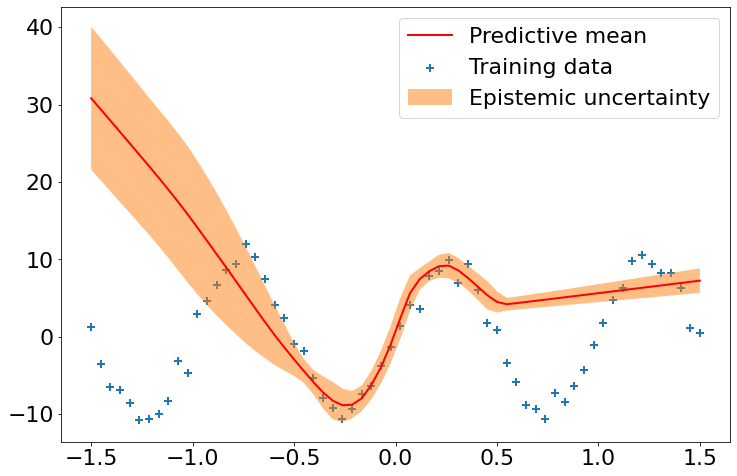

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(Input[:,0], Output[:,0], marker='+', label='Training data')
plt.plot(Input[:,0], y_mean, 'r-',              label='Predictive mean')
plt.fill_between(Input[:,0].ravel(),  y_mean + 2 * y_sigma, y_mean - 2 * y_sigma, alpha=0.5, label='Epistemic uncertainty')
plt.legend()